In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import pickle
warnings.filterwarnings('ignore')

In [2]:
# fa 객체와 회귀계수 데이터 불러오기
with open("data/coef.pickle_동행",'rb') as f:
    factor_coefficients_for_backtest = pickle.load(f)
    fa = pickle.load(f)

In [3]:
# cols와 factor_list 정의, cols는 상관분석으로 걸러진 컬럼들 factor_list는 회귀분석 후 유효한 팩터들
score = pd.read_excel('data/factor_loadings_동행.xlsx',index_col=0)
cols = score.index
factor_list = score.columns

In [4]:
factor_list

Index(['factor_1', 'factor_7', 'factor_8', 'factor_9', 'factor_10',
       'factor_22'],
      dtype='object')

In [5]:
factor_list = factor_list[:-1]

In [6]:
factor_list

Index(['factor_1', 'factor_7', 'factor_8', 'factor_9', 'factor_10'], dtype='object')

In [7]:
df_all= pd.read_excel('data/ts_rtn_동행.xlsx')
scaler = StandardScaler()
scaler.fit(df_all[cols])

StandardScaler()

In [8]:
filtered_data = df_all[cols]
filtered_data

,총자본증가율(IFRS),유형자산증가율(IFRS),투자부동산증가율(IFRS),비유동자산증가율(IFRS),유동자산증가율(IFRS),재고자산증가율(IFRS),자기자본증가율(IFRS),매출액증가율(IFRS),정상영업이익증가율(IFRS),순이익증가율(IFRS),...,비유동자산회전률(IFRS),유형자산회전율(IFRS),순운전자본회전률(IFRS),운전자본회전률(IFRS),1회전기간(IFRS),총자본투자효율(IFRS),설비투자효율(IFRS),기계투자효율(IFRS),노동소득분배율(IFRS),이윤분배율(IFRS)
0,41.31,136.95,0.0,118.90,-6.52,57.76,14.64,7.70,19.14,32.67,...,1.41,1.57,1.00,0.00,0.01,12.25,69.07,1204.12,0.00,74.74
1,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1.22,1.37,0.88,0.00,0.01,23.73,53.18,215.32,66.47,13.91
2,1.83,19.91,0.0,17.06,-15.41,-13.37,5.74,8.96,51.84,60.66,...,1.22,1.36,1.01,0.00,0.01,24.74,44.60,254.08,61.21,21.05
3,-4.46,-2.34,0.0,-1.96,-8.38,-1.77,-1.15,-4.77,-60.96,-92.58,...,1.09,1.20,1.05,0.00,0.01,23.01,41.15,239.59,72.78,1.76
4,-2.50,-6.51,0.0,-1.79,-3.69,-3.66,0.10,-1.40,-79.38,-22.83,...,1.09,1.24,1.12,0.00,0.01,20.32,37.40,236.54,80.53,1.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4258,13.47,-7.45,0.0,42.73,5.43,0.00,8.19,15.09,-1.14,-31.39,...,0.73,17.81,0.17,0.02,0.17,5.76,631.32,1148.25,74.29,34.91
4259,-2.85,10.12,0.0,10.59,-15.16,-7.05,-10.76,14.45,-29.62,-35.09,...,7.86,16.46,5.13,0.00,0.03,35.13,137.06,46254.20,41.54,16.17
4260,3.70,5.58,0.0,2.95,4.60,-5.49,-4.44,-5.96,17.91,-6.58,...,6.94,14.36,5.30,0.00,0.03,35.78,137.05,50080.69,42.21,14.31
4261,32.54,82.49,0.0,34.26,29.85,9.24,38.51,4.83,0.65,7.70,...,1.78,17.69,1.74,0.00,0.01,36.91,907.64,0.00,8.78,63.87


In [9]:
# 백테스팅 데이터 불러오기
df_original = pd.read_excel('data/kospi200_rtn_동행.xlsx', dtype = {'주식코드':str})

In [10]:
test_start_year = 2009
test_end_year = 2023 # 테스트 기간 끝 연도 (학습된 모델을 이 기간에 적용)

num_top_firms = 10 # 매년 매수할 상위 기업 수

portfolio_returns_annual = [] # 각 연도별 포트폴리오 수익률 저장
portfolio_years = [] # 수익률이 계산된 연도 저장

In [11]:
df = df_original[cols]

In [12]:
df1 = pd.merge(df_original.iloc[:, :3], df, left_index=True, right_index=True, how = 'outer')
last_df = pd.merge(df1, df_original.iloc[:, -1:], left_index=True, right_index=True, how = 'outer')

In [13]:
return_col_name = '수익률'

In [14]:
last_df

,회사명,주식코드,연도,총자본증가율(IFRS),유형자산증가율(IFRS),투자부동산증가율(IFRS),비유동자산증가율(IFRS),유동자산증가율(IFRS),재고자산증가율(IFRS),자기자본증가율(IFRS),...,유형자산회전율(IFRS),순운전자본회전률(IFRS),운전자본회전률(IFRS),1회전기간(IFRS),총자본투자효율(IFRS),설비투자효율(IFRS),기계투자효율(IFRS),노동소득분배율(IFRS),이윤분배율(IFRS),수익률
0,동화약품(주),000020,2009,41.31,136.95,0.00,118.90,-6.52,57.76,14.64,...,1.57,1.00,0.00,0.01,12.25,69.07,1204.12,0.00,74.74,-0.850125
1,(주)경방,000050,2009,85.48,107.04,0.00,96.05,17.97,-28.91,85.60,...,0.18,0.54,0.00,0.01,1.43,1.57,51.69,0.00,31.27,-0.101167
2,(주)삼양홀딩스,000070,2009,20.88,-3.47,0.00,9.83,42.49,-18.50,14.10,...,4.11,1.88,0.14,0.02,8.06,30.66,132.77,0.00,77.95,0.068063
3,(주)유한양행,000100,2009,9.26,-4.69,0.00,-0.77,24.57,13.56,12.11,...,2.17,1.11,0.39,0.01,10.94,43.17,643.22,0.00,99.40,-0.191919
4,씨제이대한통운(주),000120,2009,-55.85,-46.12,0.00,-3.75,-84.89,-5.06,-61.91,...,1.63,0.66,0.00,0.02,1.92,6.64,94.40,0.00,13.19,-0.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2864,디엘이앤씨(주),375500,2023,1.65,-2.02,-2.44,1.98,1.30,-20.54,2.97,...,41.20,0.88,0.05,0.10,11.85,680.62,7842.29,66.59,18.11,0.062500
2865,(주)카카오페이,377300,2023,13.47,-7.45,0.00,42.73,5.43,0.00,8.19,...,17.81,0.17,0.02,0.17,5.76,631.32,1148.25,74.29,34.91,-0.352294
2866,케이카(주),381970,2023,3.70,5.58,0.00,2.95,4.60,-5.49,-4.44,...,14.36,5.30,0.00,0.03,35.78,137.05,50080.69,42.21,14.31,-0.069881
2867,(주)에프앤에프,383220,2023,32.54,82.49,0.00,34.26,29.85,9.24,38.51,...,17.69,1.74,0.00,0.01,36.91,907.64,0.00,8.78,63.87,-0.532624


In [15]:
pd.DataFrame(fa.loadings_)

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,0.117107,-0.036930,0.020049,-0.003001,-0.016351,0.089675,-0.031350,0.008521,0.884903,0.072363,...,-0.011385,0.010513,0.000856,-0.013858,0.024923,0.010223,-0.014633,-0.075614,0.138146,0.033733
1,0.001268,-0.014362,-0.049979,-0.008023,0.061470,-0.014637,-0.025078,-0.006237,0.072421,-0.022946,...,-0.000222,-0.048900,-0.037227,0.030925,-0.021487,-0.013479,0.063130,0.179615,-0.114725,-0.035661
2,0.012752,0.003425,0.017608,-0.031079,-0.012906,-0.005578,-0.001514,-0.006411,0.022729,0.016766,...,-0.004738,-0.010454,-0.005780,-0.092673,-0.001458,0.027158,-0.001756,-0.001270,0.046135,0.041265
3,0.050970,0.024689,0.002836,-0.049274,-0.019966,0.073280,0.058724,0.011562,0.836391,0.084968,...,0.000181,-0.009351,-0.037333,-0.003921,0.023441,0.034751,0.023732,-0.074520,-0.084481,0.089452
4,0.022373,-0.030577,-0.103986,0.054029,0.000556,-0.002986,-0.067539,0.017277,0.252263,-0.072963,...,-0.012808,0.072799,0.039993,0.094921,0.051302,-0.012307,-0.001582,-0.001762,0.727169,-0.038064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,0.662192,-0.033951,0.162471,-0.018999,-0.056137,0.076979,-0.013650,0.031779,0.111082,0.308918,...,-0.011906,0.032849,-0.145461,-0.038281,-0.018963,0.015269,0.015624,-0.006676,-0.013492,0.055885
94,-0.014627,-0.006934,-0.038265,0.119466,0.146482,-0.000224,0.000011,0.008718,-0.014434,0.007649,...,0.002107,0.012182,0.050599,-0.009683,-0.036694,0.822192,-0.031368,-0.008512,0.022636,-0.033836
95,-0.022652,0.013525,-0.026102,-0.022410,-0.029034,-0.016439,-0.008898,0.029294,0.025431,0.048953,...,0.015303,0.188612,0.004474,0.041722,0.097532,0.029170,0.477631,-0.089569,-0.092246,-0.155051
96,-0.072592,0.060735,-0.092375,-0.002033,-0.045163,-0.018353,-0.190041,0.026906,0.097476,-0.077058,...,-0.026020,-0.067841,0.105740,0.034498,0.143777,0.034917,0.048719,0.288158,-0.240485,0.162908


In [16]:
factor_coefficients_for_backtest

factor_1     0.058028
factor_7    -0.013038
factor_8     0.019786
factor_9     0.015971
factor_10    0.011329
factor_22   -0.019007
dtype: float64

In [17]:
optim = 22
for current_year in range(test_start_year, test_end_year + 1):
    print(f"\n--- 백테스팅 연도: {current_year} ---")

    # 현재 연도(테스트 기간)의 원본 재무 변수 데이터 추출
    current_year_data_raw = last_df[last_df['연도'] == current_year].copy()

    # 재무 변수와 수익률 분리
    x_current_year_raw = current_year_data_raw.iloc[:, 3:-1]
    y_current_year = current_year_data_raw.iloc[:, -1]

    common_cols_for_factor = list(set(x_current_year_raw.columns))

    if not common_cols_for_factor:
        print(f"  {current_year}년도 데이터에 학습 기간에서 사용된 재무 변수가 없습니다. 다음 연도로 이동.")
        portfolio_returns_annual.append(0)
        portfolio_years.append(current_year)
        continue

    # 학습된 필터링된 컬럼의 순서에 맞춰 현재 데이터를 재정렬
    x_current_year_scaled = pd.DataFrame(scaler.transform(x_current_year_raw),
                                         columns=x_current_year_raw.columns,
                                         index=x_current_year_raw.index)

    # 2-2. 고정된 Factor 모델 (fa_fixed_model)을 사용하여 Factor Score 계산
    # 학습 기간에서 fit된 FactorAnalyzer 객체를 사용하여 현재 연도 데이터를 transform 합니다.
    # 이렇게 하면 현재 연도의 재무 변수들이 학습 기간에 정의된 Factor 구조에 따라 Factor Score로 변환됩니다.
    current_year_factor_scores = pd.DataFrame(fa.transform(x_current_year_scaled),
                                              columns=[f"factor_{i+1}" for i in range(optim)],
                                              index=x_current_year_raw.index)

    # 2-3. Z-score 계산 (현재 연도 Factor Score 바탕)
    # Factor Score 자체의 Z-score는 매년 해당 연도의 기업들 사이에서의 상대적 순위를 반영해야 하므로, 매년 새로 계산합니다.
    # 고정된 유의한 Factor들만 선택합니다.

    if len(factor_list) == 0:
        print(f"  {current_year}년도 데이터에 백테스팅에 사용할 유의한 Factor 컬럼이 없습니다. 다음 연도로 이동.")
        portfolio_returns_annual.append(0)
        portfolio_years.append(current_year)
        continue

    factor_scores_for_zscore = current_year_factor_scores[factor_list]

    scaler_z_period = StandardScaler()
    z_scores_period = scaler_z_period.fit_transform(factor_scores_for_zscore)
    z_scores_df_period = pd.DataFrame(z_scores_period,
                                       columns=[f"{col}_zscore" for col in factor_list],
                                       index=factor_scores_for_zscore.index)

    # 2-4. Z-score 조정 (고정된 회귀 계수 부호에 따라)
    # 학습 기간에 고정된 RLM 회귀 계수의 부호를 사용하여 Z-score의 방향성을 조정합니다.
    adjusted_z_scores_period = z_scores_df_period.copy()
    for factor in factor_list:
        # 고정된 RLM 계수가 음수이면 Z-score 순위를 반전 (높은 Z-score가 좋은 기업이 되도록)
        if factor_coefficients_for_backtest[factor] < 0:
            adjusted_z_scores_period[f"{factor}_zscore"] *= -1

    # 2-5. 기업별 최종 랭크 점수 계산 (조정된 Z-score 합산)
    # 조정된 Z-score들을 합산하여 각 기업의 최종 랭크 점수를 계산합니다.
    firm_rank_score_period = adjusted_z_scores_period.sum(axis=1)
    firm_rank_score_period = firm_rank_score_period.sort_values(ascending=False)

    # 2-6. 포트폴리오 구성: 상위 N개 기업 선정
    # 랭크 점수가 가장 높은 상위 'num_top_firms' 개 기업을 선정합니다.
    top_firms_indices = firm_rank_score_period.head(num_top_firms).index

    # 선정된 기업들의 '주식코드'와 '수익률'을 가져옵니다.
    portfolio_firms_info = current_year_data_raw.loc[top_firms_indices]
    top_firms_codes = portfolio_firms_info['주식코드'].tolist()

    if not top_firms_codes:
        print(f"  {current_year}년도에 포트폴리오에 편입할 기업이 없습니다. 다음 연도로 이동.")
        portfolio_returns_annual.append(0)
        portfolio_years.append(current_year)
        continue

    # 2-7. 포트폴리오 수익률 계산 (선정된 기업들의 현재 연도 '수익률' 평균)
    # 선정된 기업들의 해당 연도 수익률을 평균하여 포트폴리오의 연간 수익률로 간주합니다 (동일 가중 포트폴리오).
    portfolio_avg_return = portfolio_firms_info[return_col_name].mean()
    portfolio_returns_annual.append(portfolio_avg_return)
    portfolio_years.append(current_year)
    print(f"  {current_year}년도 포트폴리오 평균 수익률: {portfolio_avg_return:.2%}")


--- 백테스팅 연도: 2009 ---
  2009년도 포트폴리오 평균 수익률: 2.60%

--- 백테스팅 연도: 2010 ---
  2010년도 포트폴리오 평균 수익률: 32.78%

--- 백테스팅 연도: 2011 ---
  2011년도 포트폴리오 평균 수익률: -4.88%

--- 백테스팅 연도: 2012 ---
  2012년도 포트폴리오 평균 수익률: 39.11%

--- 백테스팅 연도: 2013 ---
  2013년도 포트폴리오 평균 수익률: 40.74%

--- 백테스팅 연도: 2014 ---
  2014년도 포트폴리오 평균 수익률: 9.03%

--- 백테스팅 연도: 2015 ---
  2015년도 포트폴리오 평균 수익률: 6.29%

--- 백테스팅 연도: 2016 ---
  2016년도 포트폴리오 평균 수익률: -3.83%

--- 백테스팅 연도: 2017 ---
  2017년도 포트폴리오 평균 수익률: -5.63%

--- 백테스팅 연도: 2018 ---
  2018년도 포트폴리오 평균 수익률: -8.46%

--- 백테스팅 연도: 2019 ---
  2019년도 포트폴리오 평균 수익률: -21.85%

--- 백테스팅 연도: 2020 ---
  2020년도 포트폴리오 평균 수익률: 68.10%

--- 백테스팅 연도: 2021 ---
  2021년도 포트폴리오 평균 수익률: -18.00%

--- 백테스팅 연도: 2022 ---
  2022년도 포트폴리오 평균 수익률: -20.76%

--- 백테스팅 연도: 2023 ---
  2023년도 포트폴리오 평균 수익률: 14.40%



--- 최종 백테스팅 연간 수익률 ---
2009    0.025950
2010    0.327791
2011   -0.048772
2012    0.391101
2013    0.407383
2014    0.090275
2015    0.062948
2016   -0.038322
2017   -0.056255
2018   -0.084582
2019   -0.218475
2020    0.680972
2021   -0.180034
2022   -0.207638
2023    0.144038
dtype: float64

--- 누적 수익률 ---
2009    1.025950
2010    1.362248
2011    1.295808
2012    1.802600
2013    2.536949
2014    2.765974
2015    2.940085
2016    2.827416
2017    2.668359
2018    2.442664
2019    1.909003
2020    3.208981
2021    2.631254
2022    2.084906
2023    2.385213
dtype: float64


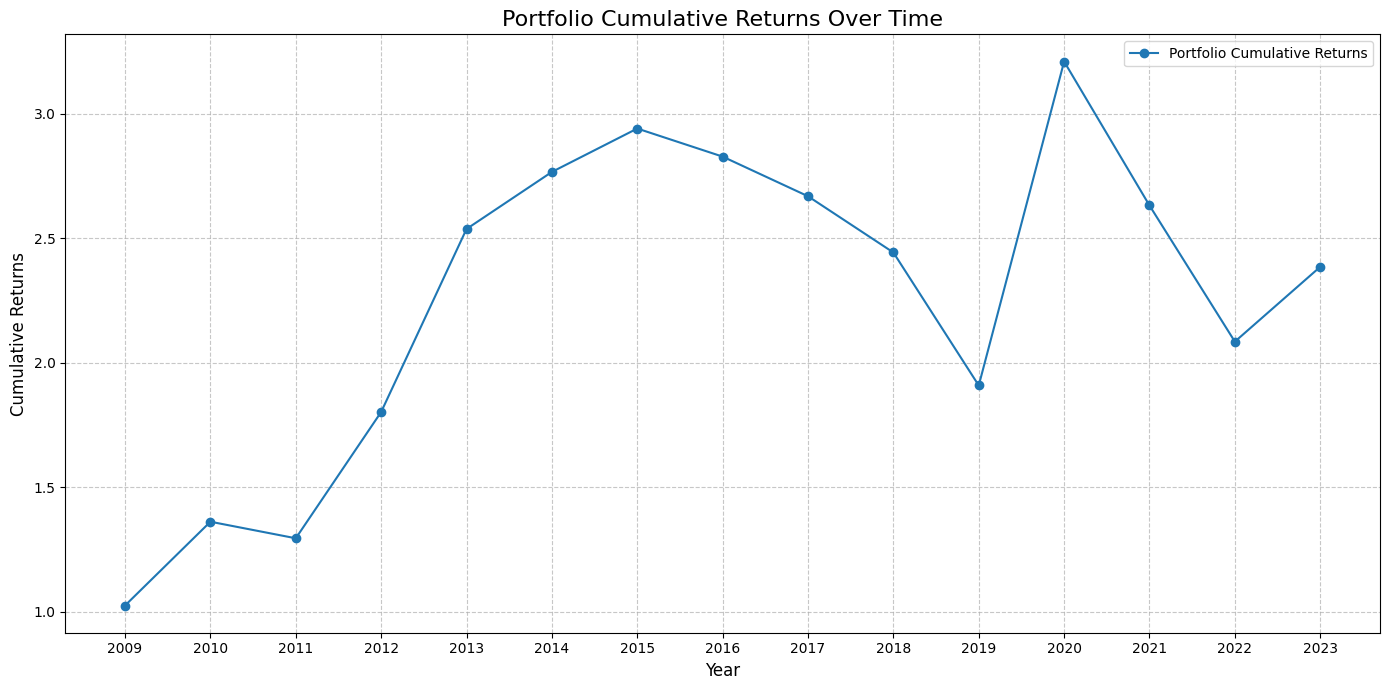


--- 백테스팅 성과 요약 ---
총 백테스팅 기간: 2009년 - 2023년 (15년)
연평균 수익률 (CAGR): 5.97%
연간 변동성 (Standard Deviation): 26.04%
샤프 비율 (무위험 이자율 2.50%): 0.13


In [18]:
if not portfolio_returns_annual:
    print("\n백테스팅을 수행할 충분한 데이터가 없거나 모든 연도에서 포트폴리오 구성에 실패했습니다.")
else:
    portfolio_returns_series = pd.Series(portfolio_returns_annual, index=portfolio_years)

    print("\n--- 최종 백테스팅 연간 수익률 ---")
    print(portfolio_returns_series)

    # 누적 수익률 계산
    cumulative_returns = (1 + portfolio_returns_series).cumprod()
    print("\n--- 누적 수익률 ---")
    print(cumulative_returns)

    # 시각화: 포트폴리오 누적 수익률 그래프
    plt.figure(figsize=(14, 7))
    plt.plot(cumulative_returns.index, cumulative_returns.values, marker='o', linestyle='-', label='Portfolio Cumulative Returns')
    plt.title('Portfolio Cumulative Returns Over Time', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Cumulative Returns', fontsize=12)
    plt.xticks(cumulative_returns.index)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

    # 추가적인 성과 지표 계산
    total_years = len(portfolio_returns_series)
    if total_years > 0:
        # 연평균 수익률 (CAGR: Compound Annual Growth Rate)
        annualized_return = (cumulative_returns.iloc[-1])**(1/total_years) - 1
        # 연간 변동성 (표준편차)
        annualized_volatility = portfolio_returns_series.std()

        # 무위험 이자율 가정 (예: 2%) - 실제 분석에서는 시장 상황에 맞는 무위험 이자율을 사용해야 합니다.
        risk_free_rate = 0.025
        sharpe_ratio = np.nan
        if annualized_volatility > 0:
            sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

        print(f"\n--- 백테스팅 성과 요약 ---")
        print(f"총 백테스팅 기간: {portfolio_returns_series.index.min()}년 - {portfolio_returns_series.index.max()}년 ({total_years}년)")
        print(f"연평균 수익률 (CAGR): {annualized_return:.2%}")
        print(f"연간 변동성 (Standard Deviation): {annualized_volatility:.2%}")
        print(f"샤프 비율 (무위험 이자율 {risk_free_rate:.2%}): {sharpe_ratio:.2f}")
    else:
        print("\n백테스팅 결과가 없어 성과 지표를 계산할 수 없습니다.")